#### Import necessary libraries 

In [3]:
!pip install xgboost

     ---------------------------------------- 89.1/89.1 MB 8.4 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, DataStructs, PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from deepchem import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from deepchem import metrics
import deepchem as dc
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#### Read in the preprocessed BBB dataset from Adenot paper

In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')

In [3]:
bbb_df.head()

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Split

#### Data preprocessing

In [5]:
X = bbb_df.iloc[:,3:].copy()
y = bbb_df.iloc[:,2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### XGBoost

In [38]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9600798403193613


#### Hyperparameter Optimization

In [67]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, ), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [68]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([2.67485943, 2.73595715, 2.80506511, 4.48494782, 4.28261852,
         4.45762024, 5.93088484, 5.66559963, 6.63777661, 7.06819701,
         5.67188582, 4.95056658]),
  'std_fit_time': array([0.04820698, 0.03602971, 0.09601457, 0.1928376 , 0.1103114 ,
         0.03314736, 0.10388977, 0.15284812, 0.71245338, 0.08151437,
         0.1971771 , 0.2937969 ]),
  'mean_score_time': array([0.04267416, 0.04471192, 0.04963107, 0.05519843, 0.05270886,
         0.05603781, 0.0604691 , 0.06381631, 0.0595634 , 0.0630578 ,
         0.06356053, 0.05368361]),
  'std_score_time': array([0.00302069, 0.00148751, 0.00561064, 0.00423853, 0.00360457,
         0.00206354, 0.00551485, 0.00696273, 0.0028864 , 0.00391021,
         0.00608553, 0.01122631]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

In [69]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'max_depth': [2, 3, 4], 'min_child_weight': [2, 3, 4]},
             scoring='roc_auc')

In [70]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([2.37974849, 2.57159061, 2.59357195, 3.33708801, 3.40624676,
         3.50691156, 4.6242837 , 5.45942121, 3.94432921]),
  'std_fit_time': array([0.12105406, 0.01251771, 0.02072793, 0.05887307, 0.07793945,
         0.17235345, 0.12722508, 0.42675303, 0.88523422]),
  'mean_score_time': array([0.05440345, 0.05865607, 0.05767469, 0.07283826, 0.06070967,
         0.07084117, 0.06970139, 0.07514939, 0.05514216]),
  'std_score_time': array([0.00192854, 0.00305161, 0.00112379, 0.02481252, 0.00403901,
         0.01255202, 0.00594756, 0.00650614, 0.01424459]),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         

In [71]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='roc_auc')

In [72]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([3.96708155, 4.27279463, 4.4532742 , 4.76944361, 4.09593797]),
  'std_fit_time': array([0.07630294, 0.15899895, 0.02678712, 0.17935836, 0.93441923]),
  'mean_score_time': array([0.05910087, 0.05876317, 0.05817542, 0.05688882, 0.0596734 ]),
  'std_score_time': array([0.00254774, 0.00260765, 0.00064539, 0.00196793, 0.01163769]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.97505435, 0.97548913, 0.97331522, 0.97461957, 0.97201087]),
  'split1_test_score': array([0.97826087, 0.97804348, 0.97728261, 0.9775    , 0.97717391]),
  'split2_test_score': array([0.9354977 , 0.93517626, 0.93474767, 0.93410479, 0.9304618 ]),
  'split3_test_score': array([0.95147541, 0.94928962, 0.94918033, 0.94939891, 0.9504918 ]),

In [73]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='roc_auc')

In [74]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([4.32079673, 4.72709889, 5.03143725, 4.70376015, 4.376794  ,
         4.67676449, 4.89907699, 4.79129786, 4.83995113, 5.12611098,
         5.46052718, 5.9314455 , 6.15877428, 6.81825795, 7.04037614,
         6.36779284]),
  'std_fit_time': array([0.04332524, 0.19531179, 0.0451747 , 0.23840222, 0.12221361,
         0.11826834, 0.0375383 , 0.06238097, 0.18351855, 0.24207132,
         0.04399506, 0.10947645, 0.09434662, 0.0978179 , 0.0590018 ,
         0.48921924]),
  'mean_score_time': array([0.06494632, 0.06409979, 0.07205725, 0.06244559, 0.06141415,
         0.06481261, 0.06313643, 0.06453261, 0.0653574 , 0.07220645,
         0.06382322, 0.07396088, 0.08004951, 0.07860785, 0.07688985,
         0.06303768]),
  'std_score_time': array([0.0075003 , 0.0062955 , 0.01264157, 0.00945987, 0.00149993,
         0.0070831 , 0.00334213, 0.0070807 , 0.00717063, 0.00885023,
         0.00296424, 0.00468612, 0.00362541, 0.00340986, 0.00504109,
         0.01128967]),
  'param_c

In [75]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'subsample': [0.75, 0.8, 0.85]},
             scoring='roc_auc')

In [76]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([5.73099174, 6.65316844, 6.31835375, 7.06990037, 6.10346785,
         5.8281558 , 5.57531157, 5.80634274, 5.72440672]),
  'std_fit_time': array([0.54721747, 0.30158667, 0.03032364, 0.43020278, 0.10749296,
         0.12622401, 0.03370121, 0.08583742, 1.33784343]),
  'mean_score_time': array([0.0687211 , 0.07429962, 0.07165818, 0.07412691, 0.06449623,
         0.06138053, 0.06188836, 0.06204624, 0.06940689]),
  'std_score_time': array([0.00323232, 0.00537535, 0.00301299, 0.00853637, 0.00153879,
         0.00260057, 0.00198401, 0.00261234, 0.01545956]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, False, False, False, False, False, Fals

In [77]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='roc_auc')

In [78]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([5.91652589, 5.69780517, 5.80159435, 5.68467894, 2.54020967]),
  'std_fit_time': array([0.16069516, 0.08312176, 0.02913618, 0.08700409, 0.5526299 ]),
  'mean_score_time': array([0.06611619, 0.06348567, 0.06391187, 0.06318169, 0.05298495]),
  'std_score_time': array([0.00224746, 0.00197647, 0.00260172, 0.00260176, 0.00982101]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.98016304, 0.98211957, 0.97766304, 0.97744565, 0.9413587 ]),
  'split1_test_score': array([0.97141304, 0.97119565, 0.97282609, 0.96815217, 0.91244565]),
  'split2_test_score': array([0.92617593, 0.92842602, 0.92821172, 0.92617593, 0.87854923]),
  'split3_test_score': array([0.94229508, 0.94240437, 0.94459016,

In [79]:
param_test7 = {
 'reg_alpha':[1e-05,1e-06,1e-04,1e-07]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 1e-06, 0.0001, 1e-07]},
             scoring='roc_auc')

In [80]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([4.5896246 , 4.98629131, 5.23935652, 6.0603406 ]),
  'std_fit_time': array([0.14551417, 0.17613436, 0.04253747, 0.40112495]),
  'mean_score_time': array([0.0538444 , 0.05863657, 0.06043043, 0.06983051]),
  'std_score_time': array([0.00335918, 0.00117951, 0.00086832, 0.00577556]),
  'param_reg_alpha': masked_array(data=[1e-05, 1e-06, 0.0001, 1e-07],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 1e-06},
   {'reg_alpha': 0.0001},
   {'reg_alpha': 1e-07}],
  'split0_test_score': array([0.98016304, 0.98016304, 0.98016304, 0.98016304]),
  'split1_test_score': array([0.97141304, 0.97141304, 0.97141304, 0.97141304]),
  'split2_test_score': array([0.92617593, 0.92617593, 0.92617593, 0.92617593]),
  'split3_test_score': array([0.94229508, 0.94229508, 0.94229508, 0.94229508]),
  'split4_test_score': array([0.95912568, 0.95912568, 0.95912568, 0.95912568]),
  'mean_

#### Optimized XGBoost

In [4]:
xg_best = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,)

In [ ]:
xg_best.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)

#### Feature Importances

In [82]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [85]:
len(non_zero_importance)

131

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

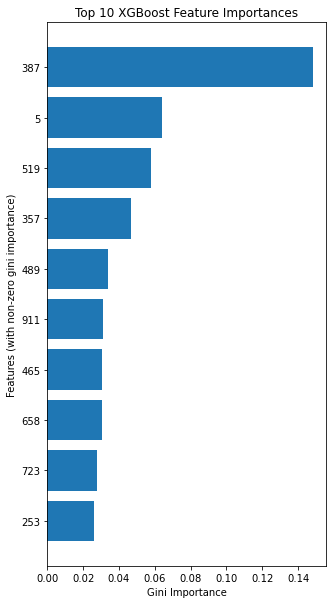

In [87]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][121:], feature_importance['Importance'][121:])
plt.title('Top 10 XGBoost Feature Importances')

In [ ]:
non_zero_features_names

### Random Split PCA, DR, and Result Metrics

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Random Split Metrics:
Accuracy: 0.9600798403193613
Balanced Accuracy: 0.9112593516209476
ROC AUC: 0.9112593516209476
Precision Score: 0.9590361445783132
Recall Score: 0.9925187032418953



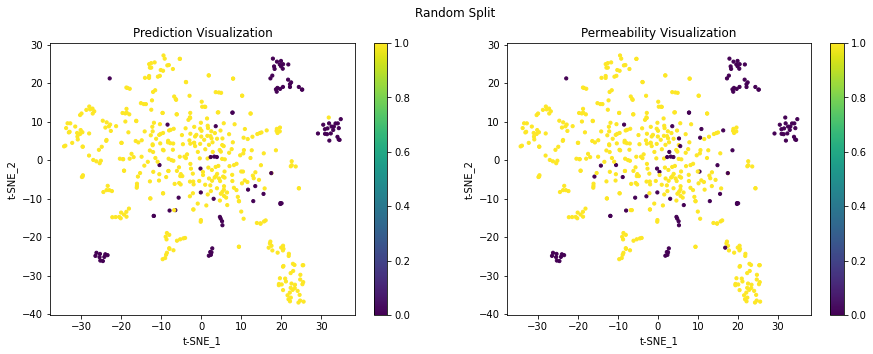

In [84]:
def plot_split(split, y_pred, y_test, t_components):
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('{} Split'.format(split))
    plt.subplot(1, 2, 1)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_pred, s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Prediction Visualization')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_test,s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Permeability Visualization')
    plt.colorbar()
    
    # Calculate how often the classifier is correct
    print("{} Split Metrics:".format(split))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
    print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))
    print("Precision Score:", metrics.precision_score(y_test, y_pred))
    print("Recall Score:", metrics.recall_score(y_test, y_pred))
    print("")

dim = 100
pca_rand = PCA(n_components=dim)
components_rand = pca_rand.fit_transform(X_test)
tsne_rand = TSNE(n_components=2)
t_components_rand = tsne_rand.fit_transform(components_rand)

plot_split('Random', y_pred, y_test, t_components_rand)


### Scaffold Split 

#### Data preprocessing

In [5]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

### Model Precitions (Classes and Probabilities)

In [6]:
# Train Decision Tree classifier
xg_best = xg_best.fit(train_scaff.X,train_scaff.y)

# Predict the response for test dataset
y_pred_scaff = xg_best.predict(test_scaff.X)

In [25]:
y_pred_scaff_prob = xg_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
31,CNC1=Nc2ccc(cc2C(=[N+]([O-])C1)c1ccccc1)Cl,0.999995
157,Oc1noc2c1CCNC2,0.999992
71,Cc1ccc2n3c4c(c2c1)CCCC4NCC3,0.999991
33,Brc1ccc2c(c1)C(=NCC(=O)N2)c1ccccn1,0.999987
68,CCN1CCC(C1)=C(c1ccccc1)c1ccccc1,0.999987
...,...,...
268,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000138
215,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,0.000117
199,COc1cccc2c1C(=O)c1c(c3c(c(c1C2=O)O)C[C@](O)(C[...,0.000080
210,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,0.000063


### Scaffold Split PCA, DR, and Result Metrics

In [51]:
dim = 100
pca_scaff = PCA(n_components=dim)
components_scaff = pca_scaff.fit_transform(test_scaff.X)

In [52]:
tsne_scaff = TSNE(n_components=2)
t_components_scaff = tsne_scaff.fit_transform(components_scaff)

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Scaffold Split Metrics:
Accuracy: 0.8413173652694611
Balanced Accuracy: 0.8172413793103448
ROC AUC: 0.8172413793103448
Precision Score: 0.78099173553719
Recall Score: 1.0



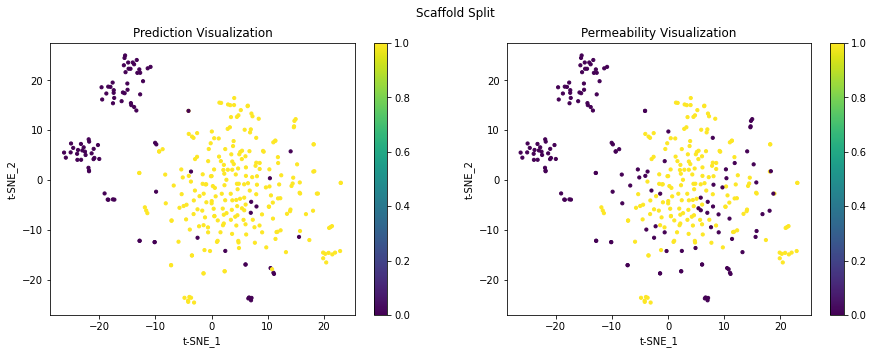

In [53]:
plot_split('Scaffold', y_pred_scaff, test_scaff.y, t_components_scaff)

## Scaffold Split Feature Importances

In [33]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [12]:
len(non_zero_importance)

115

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

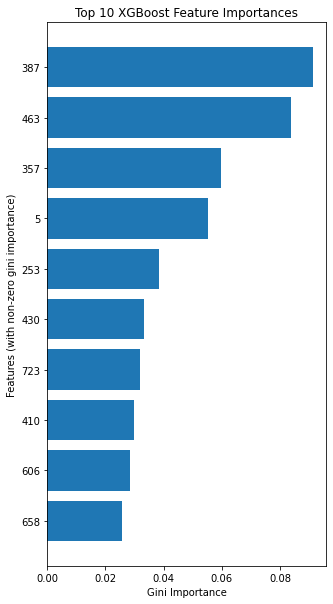

In [34]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 XGBoost Feature Importances')